In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt 
np.random.seed(1314)


class MapController:
    def __init__(self, mapSize, devicePositions):
        print('---Map Controller Initializing---')
        self.mapSize = mapSize
        self.S = self.mapSize * self.mapSize
        self.M = len(devicePositions)
        self.deviceRange = np.zeros((len(devicePositions), mapSize * mapSize), dtype=np.int)
        for index, position in enumerate(devicePositions):
            self.deviceRange[index][position[0] * mapSize + position[1]] = 1
            if position[0] > 0:
                if position[1] > 0:
                    self.deviceRange[index][position[0] * mapSize + position[1] - mapSize - 1] = 3
                self.deviceRange[index][position[0] * mapSize + position[1] - mapSize] = 2
                if position[1] < (mapSize - 1):
                    self.deviceRange[index][position[0] * mapSize + position[1] - mapSize + 1] = 3
            if position[0] < (mapSize - 1):
                if position[1] > 0:
                    self.deviceRange[index][position[0] * mapSize + position[1] + mapSize - 1] = 3
                self.deviceRange[index][position[0] * mapSize + position[1] + mapSize] = 2
                if position[1] < (mapSize - 1):
                    self.deviceRange[index][position[0] * mapSize + position[1] + mapSize + 1] = 3
            if position[1] > 0:
                self.deviceRange[index][position[0] * mapSize + position[1] - 1] = 2
            if position[1] < (mapSize - 1):
                self.deviceRange[index][position[0] * mapSize + position[1] + 1] = 2
            if position[0] > 1:
                self.deviceRange[index][position[0] * mapSize + position[1] - 2 * mapSize] = 4
            if position[0] < (mapSize - 2):
                self.deviceRange[index][position[0] * mapSize + position[1] + 2 * mapSize] = 4
            if position[1] > 1:
                self.deviceRange[index][position[0] * mapSize + position[1] - 2] = 4
            if position[1] < (mapSize - 2):
                self.deviceRange[index][position[0] * mapSize + position[1] + 2] = 4
        print('---Map Controller Initialized---')

    def get_b(self, task, position, at):
        M = self.M
        S = self.S
        G = np.zeros((M+S+1,1))
        F = np.zeros((M+S+1,1))
        G[position] = 1
        if at == 0:
            F[position] = 1
        else:
            F[S-1+at] = 1
        b = np.zeros((3*M+3*S+4,1))
        b[0,0] = task[0]
        b[1:M+S+2] = task[1] * G + task[2] * F
        b[M+S+2:2*M+2*S+3] = G + F
        b[2*M+2*S+3:] = task[3] * F
        return b

    def get_zts(self, positions):
        print('---MC: Generating zts---')
        zts = []
        for position in positions:
            zt = np.zeros(self.M+2)
            zt[:2] = 1
            zt[2:] = (self.deviceRange.T[position] > 0).astype('int')
            zts.append(zt)
        print('---MC: Zts generated---')
        return zts               


    def get_mus(self, TCount, 
        DCapacityMin, DCapacityMax,
        CCapacityMin, CCapacityMax, LCapacityMin, LCapacityMax,
        D2DBaseDelay, CellularBaseDelayMin, CellularBaseDelayMax,
        CloudBaseDelayMin, CloudBaseDelayMax,
        D2DNSpdMins, D2DNSpdMaxs, Spd2Device, Spd2Cloud, 
        positions):
        print('---MC: Generating mus---')
        print('- Time slot count:', TCount)
        print('-- Computing Capacity Parameters --')
        print('- Device Computing Capacity Range:', DCapacityMin, '-', DCapacityMax)
        print('- Cloud Computing Capacity Range:', CCapacityMin, '-', CCapacityMax)
        print('- Local Computing Capacity Range:', LCapacityMin, '-', LCapacityMax)
        print('-- Base Delay Parameters --')
        print('- D2D Base Delay:', D2DBaseDelay)
        print('- Cellular Base Delay Range:', CellularBaseDelayMin, '-', CellularBaseDelayMax)
        print('- Cloud Base Delay Range:', CloudBaseDelayMin, '-', CloudBaseDelayMax)
        print('-- Transmission Speed Parameters --')
        print('- D2D Speed Mins:', D2DNSpdMins)
        print('- D2D Speed Maxs:', D2DNSpdMaxs)
        print('- Speed between D2D devices:', Spd2Device)
        print('- Speed to cloud device', Spd2Cloud)
        M = self.M
        S = self.S
        mus = []
        positionRange = self.deviceRange.T
        for time in range(TCount):
            must = []
            SpdMatrix = Spd2Device * np.ones((S,M))
            for i in range(1, 5):
                SpdMatrix[positionRange == i] = np.random.uniform(D2DNSpdMins[i], D2DNSpdMaxs[i], np.sum(positionRange == i))
            baseMatrix = D2DBaseDelay * np.ones((S,M))
            baseMatrix[positionRange == 0] = np.random.uniform(CellularBaseDelayMin, CellularBaseDelayMax, np.sum(positionRange == 0))
            dBaseMatrix = np.random.uniform(CellularBaseDelayMin, CellularBaseDelayMax, (M, M))
            dBaseMatrix = np.triu(dBaseMatrix)
            dBaseMatrix = dBaseMatrix + dBaseMatrix.T
            cloudBase = np.random.uniform(CloudBaseDelayMin, CloudBaseDelayMax)

            mu = np.zeros((3*M+3*S+4,1)) 
            mu[0,0] = 1/np.random.uniform(LCapacityMin, LCapacityMax) 
            mu[S+1,0] = 1/Spd2Cloud 
            mu[S+2:S+2+M,0] = 1/SpdMatrix[positions[time]] 
            # mu[S+2+M:2*S+2+M,0] = 0 # S+2+M～2*S+1+M 
            mu[2*S+2+M,0] = cloudBase # 2*S+2+M 
            mu[2*S+3+M:2*S+2*M+3,0] = baseMatrix[positions[time]] # 2*S+3+M ～ 2*S+2*M+2 
            mu[2*S+2*M+3:,] = 1 
            mu[2*S+2*M+3+positions[time],0] = 0
            must.append(mu)

            mu = np.zeros((3*M+3*S+4,1))
            mu[0,0] = 1/np.random.uniform(CCapacityMin, CCapacityMax)
            mu[1:S+1,0] = 1/Spd2Cloud
            mu[S+1,0] = 0
            mu[S+2:S+2+M,0] = 1/Spd2Cloud
            mu[S+2+M:2*S+2+M,0] = cloudBase
            mu[2*S+2+M,0] = 0
            mu[2*S+3+M:2*S+2*M+3,0] = cloudBase
            mu[2*S+2*M+3:,] = 1
            mu[3*S+2*M+3,0] = 0
            must.append(mu)

            for i in range(M):
                mu = np.zeros((3*M+3*S+4,1))
                mu[0,0] = 1/np.random.uniform(DCapacityMin, DCapacityMax)
                mu[1:S+1,0] = 1/(SpdMatrix.T[i])
                mu[S+1,0] = 1/Spd2Cloud
                mu[S+2:S+2+M,0] = 1/Spd2Device
                mu[S+2+M:2*S+2+M,0] = baseMatrix.T[i]
                mu[2*S+2+M,0] = cloudBase
                mu[2*S+3+M:2*S+2*M+3,0] = dBaseMatrix[i]
                mu[2*S+2*M+3:,] = 1
                mu[3*S+2*M+4+i,0] = 0
                must.append(mu)

            mus.append(must)
        print('---MC: Mus generated---')
        return mus

class PathController:
    def __init__(self):
        print('---Path Controller Initialized---')

    def getPath(self, MinSpd, MaxSpd, PMax, TCount, mapSize):
        print('---PC: Generating user mobility with RWP---')
        print('- Minimal Speed:', MinSpd, ', Maximal Speed:', MaxSpd)
        print('- Maximal Pause Time:', PMax, ', Map Size:', mapSize)
        print('- Time of mobility:', TCount)
        positionFloat = np.zeros(2)
        positions = []
        count = 0


        while count < TCount:
        
            targetPosition = np.random.uniform(0, mapSize, 2)
            directionVec = targetPosition - positionFloat
            directionVec = directionVec / np.linalg.norm(directionVec)
            currentSpd = np.random.uniform(MinSpd, MaxSpd)
            
            while True:
                if count > TCount:
                    break
                if np.linalg.norm(positionFloat - targetPosition) < currentSpd:
                    count = count + 1
                    if count > TCount:
                        break
                    positionFloat = targetPosition
                    tempPos = positionFloat.astype('int')
                    positions.append(tempPos[0] * mapSize + tempPos[1])
                    pauseTime = int(np.random.uniform(0, PMax))
                    for _ in range(pauseTime):
                        count = count + 1
                        if count > TCount:
                            break
                        tempPos = positionFloat.astype('int')
                        positions.append(tempPos[0] * mapSize + tempPos[1])
                    break
                count = count + 1
                positionFloat = positionFloat + directionVec * currentSpd
                tempPos = positionFloat.astype('int')
                positions.append(tempPos[0] * mapSize + tempPos[1])
        print('---PC: User mobility generated---')            
        return positions  

class TaskController:

    def get_tasks(self, compute, transmit, switchC, switchDMax,
        TCount, interval):
        print('---TC: Generating tasks---')
        print('- Computing Demand Type:', compute)
        print('- Transmission Demand Type:', transmit)
        print('- Context transmission demand type:', switchC)
        print('- Max Switch Deployment Time:', switchDMax)
        NCompute = len(compute)
        NTransmit = len(transmit)
        NSwitchC = len(switchC)
        count = 0
        tasks = []
        while count < TCount:
            computeIndex = int(np.random.uniform(0, NCompute))
            transmitIndex = int(np.random.uniform(0, NTransmit))
            switchCIndex = int(np.random.uniform(0, NSwitchC))
            switchD = np.random.uniform(0, switchDMax)
            for i in range(interval):
                count = count + 1
                tasks.append((compute[computeIndex], transmit[transmitIndex],
                    switchC[switchCIndex], switchD))
                if count >= TCount:
                    break
        print('---TC: Tasks generated---')
        return tasks

class OPTAlgorithm:
    def __init__(self, tasks, mu, z, NStep, positions, M, MC):
        print('---Offline Optimal Algorithm Initializing---')
        self.tasks = tasks
        self.mu = mu
        self.z = z
        self.lastZ = np.zeros(M+2)
        self.lastZ[0] = 1
        self.minSums = [np.zeros(M+2)]
        self.count = 0
        self.positions = positions
        self.NStep = NStep
        self.M = M
        self.MC = MC
        print('---Offline Optimal Algorithm Initialized---')
    
    def step(self):
        if self.count >= self.NStep:
            print('---OOA: No more steps, fail to operate---')
            return
        bts = []
        for (index, p) in enumerate(self.lastZ):
            if p == 1:
                bts.append((index, self.MC.get_b(self.tasks[self.count], self.positions[self.count], index)))
        self.lastZ = self.z[self.count]
        self.minSums.append(np.ones(self.M+2) * float('inf'))
        for (index, p) in enumerate(self.z[self.count]):
            if p == 1:
                for (lastIndex, bt) in bts:
                    r = self.evaluate(bt, self.mu[self.count][index])
                    if r + self.minSums[-2][lastIndex] < self.minSums[-1][index]:
                        self.minSums[-1][index] = r + self.minSums[-2][lastIndex]
        self.count = self.count + 1
        return np.min(self.minSums[-1])
    
    def run_all(self, gap):
        print('---OOA: Running Optimal Algorithm---')
        avg_cost = []
        while self.count < self.NStep:
            currentSum = self.step()
            if self.count % gap == 0:
                avg_cost.append(currentSum / self.count)
            if self.count % 1000 == 0:
                print('- Step:', self.count, '/', self.NStep)
                print('- Current avg sum:', currentSum / self.count)
        print('---OOA: Optimal Algorithm Finished---')
        return avg_cost

    def evaluate(self, bt, mu):
        return bt.T@mu


class OnlineAlgorithmController:
    def __init__(self, algorithm, tasks, mu, z, NStep, positions, MC):
        print('---Online Algorithm Controller Initializing---')
        self.tasks = tasks
        self.mu = mu
        self.z = z
        self.count = 0
        self.NStep = NStep
        self.algorithm = algorithm
        self.positions = positions
        self.MC = MC
        self.at = 0
        print('---Online Algorithm Controller Initialized---')
        print('- Algorithm:', type(algorithm))
        print('- Total steps:', NStep)

    def step(self):
        if self.count >= self.NStep:
            print('---OAC: No more steps, fail to operate---')
            return
        self.b = self.MC.get_b(self.tasks[self.count], self.positions[self.count], self.at)
        self.at = self.algorithm.choose(self.z[self.count], self.b)
        r = self.evaluate()
        self.algorithm.update(r, self.b)
        # TODO: cumulate info and print the image
        self.count = self.count + 1
        return r[0][0]

    def run_all(self, gap):
        print('---OAC: Running algorithm', type(self.algorithm), '---')
        sum = 0
        avg_cost = []
        while self.count < self.NStep:
            sum += self.step()
            if self.count % gap == 0:
                avg_cost.append(sum / self.count)
            if self.count % 1000 == 0:
                print('- Step:', self.count, '/', self.NStep)
                print('- Current avg sum:', sum / self.count)
        print('---OAC: Algorithm', self.algorithm, 'finished---')
        return avg_cost

    
    def evaluate(self):
        if self.count >= self.NStep:
            print('---OAC: No more steps, fail to operate---')
            return -1
        r = self.b.T@self.mu[self.count][self.at]
        return r

class LinUCB:
    def __init__(self, M, S, alpha):
        print('---LinUCB initializing---')
        #  Bi，Bi = B[i-1]
        self.B = [np.identity(3*M+3*S+4) for count in range(1, M+3)]
        #  mui，mui = mu[i-1]
        self.mu = [np.zeros((3*M+3*S+4,1)) for count in range(1, M+3)]
        self.f = [np.zeros((3*M+3*S+4,1)) for count in range(1, M+3)]
        self.alpha = alpha
        self.selectIndex = 0
        print('---LinUCB initialized---')

    def choose(self, zt, bt):
        minUCB = float('infinity')
        for index, p in enumerate(zt):
            if p == 1:
                temp = bt.T @ self.mu[index] - self.alpha * math.sqrt(bt.T@self.B[index]@bt)
                if (temp < minUCB)[0][0]:
                    minUCB = temp
                    self.selectIndex = index
        return self.selectIndex

    def update(self, r, bt):
        self.f[self.selectIndex] = self.f[self.selectIndex] + r * bt
        self.B[self.selectIndex] = self.B[self.selectIndex] + bt @ bt.T
        self.mu[self.selectIndex] = np.linalg.inv(self.B[self.selectIndex]) @ self.f[self.selectIndex]

class ThompsonSamping:
    def __init__(self, M, S, v):
        print('---TS initializing---')
        #  Bi，Bi = B[i-1]
        self.B = [np.identity(3*M+3*S+4) for count in range(1, M+3)]
        #  mui，mui = mu[i-1]
        self.mu = [np.zeros((3*M+3*S+4,1)) for count in range(1, M+3)]
        self.f = [np.zeros((3*M+3*S+4,1)) for count in range(1, M+3)]
        self.v = v
        self.selectIndex = 0
        print('---TS initialized---')

    def choose(self, zt, bt):
        minTS = float('infinity')
        for index, p in enumerate(zt):
            if p == 1:
                temp = np.random.normal(bt.T@self.mu[index], self.v * np.sqrt(bt.T@np.linalg.inv(self.B[index])@bt))
                if (temp < minTS)[0][0]:
                    minTS = temp
                    self.selectIndex = index
        return self.selectIndex

    def update(self, r, bt):
        self.f[self.selectIndex] = self.f[self.selectIndex] + r * bt
        self.B[self.selectIndex] = self.B[self.selectIndex] + bt @ bt.T
        self.mu[self.selectIndex] = np.linalg.inv(self.B[self.selectIndex]) @ self.f[self.selectIndex]

class PureRandom:
    def __init__(self, M):
        self.total = M + 2
        print('---Pure Random initialized---')

    def choose(self, zt, bt):
        while True:
            testIndex = int(np.random.uniform(0, self.total))
            if zt[testIndex] == 1:
                return testIndex

    def update(self, r, bt):
        pass

In [2]:
mapSize = 5 
devicePositions = [(0,0),(0,2),(0,4),
                   (2,0),(2,2),(2,4),
                   (4,0),(4,2),(4,4)]
S = mapSize * mapSize
M = len(devicePositions)

TCount = 10000
DCapacityMin = 10000
DCapacityMax = 15000
CCapacityMin = 100000
CCapacityMax = 120000
LCapacityMin = 1500
LCapacityMax = 2500

D2DBaseDelay = 0.1
CellularBaseDelayMin = 0.5
CellularBaseDelayMax = 5
CloudBaseDelayMin = 50
CloudBaseDelayMax = 100

D2DNSpdMins = [0, 1000, 100, 50, 10]
D2DNSpdMaxs = [0, 1500, 150, 75, 15]
Spd2Device = 500
Spd2Cloud = 500


MinSpd = 0.5
MaxSpd = 1.5
PMax = 5

compute = [100000, 10000, 2500, 250]
transmit = [2000, 40, 8]
switchC = [1000, 10, 0]
switchDMax = 10
interval = 5

alpha = 0.1
# Thompson Samling
v = 0.05

In [3]:

mc = MapController(mapSize=5, devicePositions=devicePositions)
pc = PathController()
tc = TaskController()
positions = pc.getPath(MinSpd, MaxSpd, PMax, TCount, mapSize)
tasks = tc.get_tasks(compute,transmit,switchC,switchDMax,TCount,interval)
zts = mc.get_zts(positions)
mus = mc.get_mus(TCount, 
    DCapacityMin, DCapacityMax, CCapacityMin, CCapacityMax, LCapacityMin, LCapacityMax,
    D2DBaseDelay, CellularBaseDelayMin, CellularBaseDelayMax, CloudBaseDelayMin, CloudBaseDelayMax,
    D2DNSpdMins, D2DNSpdMaxs, Spd2Device, Spd2Cloud,
    positions)


# OnlineAlgorithmController

linUCB = LinUCB(M, S, alpha)
ts = ThompsonSamping(M, S, v)
pr = PureRandom(M)

oacUCB = OnlineAlgorithmController(linUCB, tasks, mus, zts, TCount, positions, mc)
oacTS  = OnlineAlgorithmController(ts, tasks, mus, zts, TCount, positions, mc)
oacPR  = OnlineAlgorithmController(pr, tasks, mus, zts, TCount, positions, mc)
ooa    = OPTAlgorithm(tasks, mus, zts, TCount, positions, M, mc)

---Map Controller Initializing---
---Map Controller Initialized---
---Path Controller Initialized---
---PC: Generating user mobility with RWP---
- Minimal Speed: 0.5 , Maximal Speed: 1.5
- Maximal Pause Time: 5 , Map Size: 5
- Time of mobility: 10000
---PC: User mobility generated---
---TC: Generating tasks---
- Computing Demand Type: [100000, 10000, 2500, 250]
- Transmission Demand Type: [2000, 40, 8]
- Context transmission demand type: [1000, 10, 0]
- Max Switch Deployment Time: 10
---TC: Tasks generated---
---MC: Generating zts---
---MC: Zts generated---
---MC: Generating mus---
- Time slot count: 10000
-- Computing Capacity Parameters --
- Device Computing Capacity Range: 10000 - 15000
- Cloud Computing Capacity Range: 100000 - 120000
- Local Computing Capacity Range: 1500 - 2500
-- Base Delay Parameters --
- D2D Base Delay: 0.1
- Cellular Base Delay Range: 0.5 - 5
- Cloud Base Delay Range: 50 - 100
-- Transmission Speed Parameters --
- D2D Speed Mins: [0, 1000, 100, 50, 10]
- D2D 

---OOA: Running Optimal Algorithm---
- Step: 1000 / 10000
- Current avg sum: 6.173253022823718
- Step: 2000 / 10000
- Current avg sum: 6.711815836131855
- Step: 3000 / 10000
- Current avg sum: 6.775009901601271
- Step: 4000 / 10000
- Current avg sum: 6.783064755117597
- Step: 5000 / 10000
- Current avg sum: 6.675821575168818
- Step: 6000 / 10000
- Current avg sum: 6.667263788033815
- Step: 7000 / 10000
- Current avg sum: 6.696440396321644
- Step: 8000 / 10000
- Current avg sum: 6.573991135006288
- Step: 9000 / 10000
- Current avg sum: 6.6206403856098
- Step: 10000 / 10000
- Current avg sum: 6.635628244914231
---OOA: Optimal Algorithm Finished---
---OAC: Running algorithm <class '__main__.LinUCB'> ---
- Step: 1000 / 10000
- Current avg sum: 13.273754579582658
- Step: 2000 / 10000
- Current avg sum: 14.79671806426499
- Step: 3000 / 10000
- Current avg sum: 14.66022215419782
- Step: 4000 / 10000
- Current avg sum: 14.807838077920492
- Step: 5000 / 10000
- Current avg sum: 14.7381451038476

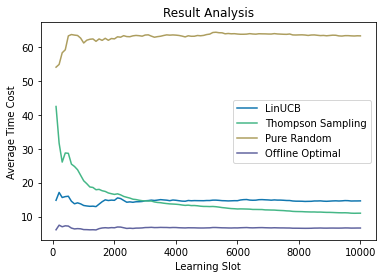

In [4]:
gap = 100

cost_ooa = ooa.run_all(gap)
cost_ucb = oacUCB.run_all(gap)
cost_ts  = oacTS.run_all(gap)
cost_pr  = oacPR.run_all(gap)

xs = range(gap, gap + TCount, gap)

plt.title('Result Analysis')
 
plt.plot(xs, cost_ucb,  color='#1177b0', label='LinUCB')
plt.plot(xs, cost_ts, color='#45b787', label='Thompson Sampling')
plt.plot(xs, cost_pr, color='#ad9e5f', label='Pure Random')
plt.plot(xs, cost_ooa,color='#61649f', label='Offline Optimal')
plt.legend()
 
plt.xlabel('Learning Slot')
plt.ylabel('Average Time Cost')
plt.savefig('resultAlgorithm.png')
plt.show()

---TS initializing---
---TS initialized---
---TS initializing---
---TS initialized---
---TS initializing---
---TS initialized---
---TS initializing---
---TS initialized---
---TS initializing---
---TS initialized---
---TS initializing---
---TS initialized---
---Online Algorithm Controller Initializing---
---Online Algorithm Controller Initialized---
- Algorithm: <class '__main__.ThompsonSamping'>
- Total steps: 10000
---Online Algorithm Controller Initializing---
---Online Algorithm Controller Initialized---
- Algorithm: <class '__main__.ThompsonSamping'>
- Total steps: 10000
---Online Algorithm Controller Initializing---
---Online Algorithm Controller Initialized---
- Algorithm: <class '__main__.ThompsonSamping'>
- Total steps: 10000
---Online Algorithm Controller Initializing---
---Online Algorithm Controller Initialized---
- Algorithm: <class '__main__.ThompsonSamping'>
- Total steps: 10000
---Online Algorithm Controller Initializing---
---Online Algorithm Controller Initialized---
-

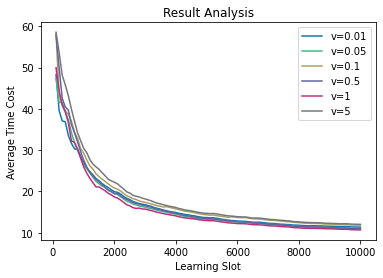

In [5]:
v1 = 0.01
v2 = 0.05
v3 = 0.1
v4 = 0.5
v5 = 1
v6 = 5

ts_1 = ThompsonSamping(M, S, v1)
ts_2 = ThompsonSamping(M, S, v2)
ts_3 = ThompsonSamping(M, S, v3)
ts_4 = ThompsonSamping(M, S, v4)
ts_5 = ThompsonSamping(M, S, v5)
ts_6 = ThompsonSamping(M, S, v6)

oacTS_1  = OnlineAlgorithmController(ts_1, tasks, mus, zts, TCount, positions, mc)
oacTS_2  = OnlineAlgorithmController(ts_2, tasks, mus, zts, TCount, positions, mc)
oacTS_3  = OnlineAlgorithmController(ts_3, tasks, mus, zts, TCount, positions, mc)
oacTS_4  = OnlineAlgorithmController(ts_4, tasks, mus, zts, TCount, positions, mc)
oacTS_5  = OnlineAlgorithmController(ts_5, tasks, mus, zts, TCount, positions, mc)
oacTS_6  = OnlineAlgorithmController(ts_6, tasks, mus, zts, TCount, positions, mc)

cost_ts_1  = oacTS_1.run_all(gap)
cost_ts_2  = oacTS_2.run_all(gap)
cost_ts_3  = oacTS_3.run_all(gap)
cost_ts_4  = oacTS_4.run_all(gap)
cost_ts_5  = oacTS_5.run_all(gap)
cost_ts_6  = oacTS_6.run_all(gap)


plt.title('Result Analysis')
 
plt.plot(xs, cost_ts_1, color='#1177b0', label='v=0.01')
plt.plot(xs, cost_ts_2, color='#45b787', label='v=0.05')
plt.plot(xs, cost_ts_3, color='#ad9e5f', label='v=0.1')
plt.plot(xs, cost_ts_4, color='#61649f', label='v=0.5')
plt.plot(xs, cost_ts_5, color='#ba2f7b', label='v=1')
plt.plot(xs, cost_ts_6, color='#74787a', label='v=5')
plt.legend()
 
plt.xlabel('Learning Slot')
plt.ylabel('Average Time Cost')
plt.savefig('resultVValue.png')
plt.show()

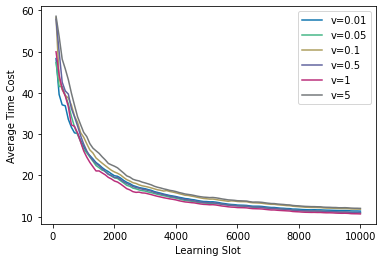

In [6]:
plt.plot(xs, cost_ts_1, color='#1177b0', label='v=0.01')
plt.plot(xs, cost_ts_2, color='#45b787', label='v=0.05')
plt.plot(xs, cost_ts_3, color='#ad9e5f', label='v=0.1')
plt.plot(xs, cost_ts_4, color='#61649f', label='v=0.5')
plt.plot(xs, cost_ts_5, color='#ba2f7b', label='v=1')
plt.plot(xs, cost_ts_6, color='#74787a', label='v=5')
plt.legend()
 
plt.xlabel('Learning Slot')
plt.ylabel('Average Time Cost')
plt.savefig('resultVValue.png', dpi=300)